In [1]:
"""Load packages"""

import sys, os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)

dump.raw.txt
model_02.txt
model_03.txt
dump_svm.raw.txt
model_01.txt
bst_svm_model.pkl
data_train.svm
.DS_Store
model_04.txt
Boosted Trees.ipynb
confusion.csv
dtest.svm
data_test.svm
test_file.txt
data_train_lol_whoops.svm
bst_model.pkl
dtrain.svm
data_test_lol_whoops.svm
numerical representation.ipynb
image.png
y_u_no_work.txt
.DS_Store
elife-16965-supp1-v4.xlsx
Boosted Trees.ipynb
elife-16965-supp2-v4.xlsx
gb1_whole_dataset_raw.csv
numerical representation-checkpoint.ipynb
Boosted Trees-checkpoint.ipynb


In [3]:
xgb.__version__

'1.1.0-SNAPSHOT'

In [4]:
os.getcwd()

'/Users/taumoefolaugh/Desktop/Applied Machine Learning'

In [150]:
# Link to dataset
# https://elifesciences.org/articles/16965

# problem statement and y-variable

Very few mutations are truly beneficial, which makes protein engineering via directed evolution challenging. The number of mutants that can be screened is also limited by the screening step, which can be experimentally and computationally expensive. How can we maximize the information that we retrieve from each screen to derive a mutant with desirable properties? Here, I use machine learning to determine whether physiochemical descriptions of amino acids are predictive of empirically determined fitness value in protein GB1. My y-variable is fitness, as defined in the eLife paper.

In [6]:
"""zScale parameters of 20 amino acids"""

zscale = {'A': [0.24,  -2.32,  0.60, -0.14,  1.30],
          'C': [0.84,  -1.67,  3.71,  0.18, -2.65],
          'D': [3.98,   0.93,  1.93, -2.46,  0.75],
          'E': [3.11,   0.26, -0.11, -0.34, -0.25],
          'F': [-4.22,  1.94,  1.06,  0.54, -0.62],
          'G': [2.05,  -4.06,  0.36, -0.82, -0.38],
          'H': [2.47,   1.95,  0.26,  3.90,  0.09],
          'I': [-3.89, -1.73, -1.71, -0.84,  0.26],
          'K': [2.29,   0.89, -2.49,  1.49,  0.31],
          'L': [-4.28, -1.30, -1.49, -0.72,  0.84],
          'M': [-2.85, -0.22,  0.47,  1.94, -0.98],
          'N': [3.05,   1.62,  1.04, -1.15,  1.61],
          'P': [-1.66,  0.27,  1.84,  0.70,  2.00],
          'Q': [1.75,   0.50, -1.44, -1.34,  0.66],
          'R': [3.52,   2.50, -3.50,  1.99, -0.17],
          'S': [2.39,  -1.07,  1.15, -1.39,  0.67],
          'T': [0.75,  -2.18, -1.12, -1.46, -0.40],
          'V': [-2.59, -2.64, -1.54, -0.85, -0.02],
          'W': [-4.36,  3.94,  0.59,  3.44, -1.59],
          'Y': [-2.54,  2.44,  0.43,  0.04, -1.47],
          '-': [0.00,   0.00,  0.00,  0.00,  0.00]}

In [7]:
""" Load data that was originally named elife-16965-supp1-v4.xlsx"""

file = 'proteinGB1_mlde_project/gb1_whole_dataset_raw.csv'
data = open(file, 'r').readlines()

In [8]:
"""Practice converting sequence matrix into a single vector expression with WT VDGV"""

sites = 'VDGV'
numerical_sites_WT = []
for _ in sites:
    vector = zscale[_]
    numerical_sites_WT.append(vector)
numerical_sites_WT = np.array(numerical_sites_WT)
print(numerical_sites_WT)
print(numerical_sites_WT.shape)
numerical_sites_WT_collapsed = numerical_sites_WT.ravel()
print(numerical_sites_WT_collapsed)
print(numerical_sites_WT_collapsed.shape)

[[-2.59 -2.64 -1.54 -0.85 -0.02]
 [ 3.98  0.93  1.93 -2.46  0.75]
 [ 2.05 -4.06  0.36 -0.82 -0.38]
 [-2.59 -2.64 -1.54 -0.85 -0.02]]
(4, 5)
[-2.59 -2.64 -1.54 -0.85 -0.02  3.98  0.93  1.93 -2.46  0.75  2.05 -4.06
  0.36 -0.82 -0.38 -2.59 -2.64 -1.54 -0.85 -0.02]
(20,)


In [9]:
"""Convert sequence information/categorical data into numerical form/matrices"""

numerical_sites_dataset = [numerical_sites_WT_collapsed]
numerical_sites_target = [1]
count = 0
for i, _ in enumerate(data):
    mutant_sites = numerical_sites_WT
    if i <= 1:
        continue
#     elif i <= 5:
    else:
        mutations = _.split(',')[0]
#         print(mutations)
        fitness = float(_.strip().split(',')[4])
        mutant_sites[0] = zscale[mutations[0]]
        mutant_sites[1] = zscale[mutations[1]]
        mutant_sites[2] = zscale[mutations[2]]
        mutant_sites[3] = zscale[mutations[3]]
#         print(mutations)
#         print(mutant_sites)
        mutant_sites_collapsed = mutant_sites.ravel()
#         print(mutant_sites_collapsed)
        numerical_sites_dataset = np.append(numerical_sites_dataset, [mutant_sites_collapsed], axis = 0)
        numerical_sites_target.append(fitness)
    if i % 2000 == 0:
        count += 1
        print('loading...' + str(((2000*(count))/149361)*100) + '%')
#     else:
#         break

numerical_sites_dataset = np.array(numerical_sites_dataset)
print(numerical_sites_dataset, numerical_sites_dataset.shape)
numerical_sites_target = np.array(numerical_sites_target)
print(numerical_sites_target, numerical_sites_target.shape)

loading...1.3390376336526937%
loading...2.6780752673053874%
loading...4.0171129009580815%
loading...5.356150534610775%
loading...6.695188168263469%
loading...8.034225801916163%
loading...9.373263435568857%
loading...10.71230106922155%
loading...12.051338702874244%
loading...13.390376336526938%
loading...14.72941397017963%
loading...16.068451603832326%
loading...17.40748923748502%
loading...18.746526871137714%
loading...20.08556450479041%
loading...21.4246021384431%
loading...22.763639772095797%
loading...24.102677405748487%
loading...25.44171503940118%
loading...26.780752673053875%
loading...28.11979030670657%
loading...29.45882794035926%
loading...30.797865574011958%
loading...32.13690320766465%
loading...33.475940841317346%
loading...34.81497847497004%
loading...36.154016108622734%
loading...37.49305374227543%
loading...38.832091375928115%
loading...40.17112900958082%
loading...41.51016664323351%
loading...42.8492042768862%
loading...44.18824191053889%
loading...45.52727954419159%
lo

In [11]:
"""Make list of mutant sequences"""

mutants = ['VDGV']
for i, _ in enumerate(data):
    if i <= 1:
        continue
    else:
        mutations = _.split(',')[0]
        mutants.append(mutations)

In [117]:
""" Generate pandas data frame of numerically represented amino acid sequence and target variable with indeces. """

# X = numerical_sites_dataset
# y = numerical_sites_target

X = pd.DataFrame(numerical_sites_dataset,
                 columns=['Pos39_Z1', 'Pos39_Z2', 'Pos39_Z3', 'Pos39_Z4', 'Pos39_Z5',
                        'Pos40_Z1', 'Pos40_Z2', 'Pos40_Z3', 'Pos40_Z4', 'Pos40_Z5',
                        'Pos41_Z1', 'Pos41_Z2', 'Pos41_Z3', 'Pos41_Z4', 'Pos41_Z5',
                        'Pos54_Z1', 'Pos54_Z2', 'Pos54_Z3', 'Pos54_Z4', 'Pos54_Z5'])
# y = pd.Series(numerical_sites_target)
y = pd.DataFrame(list(zip(mutants, numerical_sites_target)), columns=['sequence', 'fitness'])

# head and shape of data

In [151]:
X.head()

,Pos39_Z1,Pos39_Z2,Pos39_Z3,Pos39_Z4,Pos39_Z5,Pos40_Z1,Pos40_Z2,Pos40_Z3,Pos40_Z4,Pos40_Z5,Pos41_Z1,Pos41_Z2,Pos41_Z3,Pos41_Z4,Pos41_Z5,Pos54_Z1,Pos54_Z2,Pos54_Z3,Pos54_Z4,Pos54_Z5
0,0.24,-2.32,0.60,-0.14,1.30,3.98,0.93,1.93,-2.46,0.75,2.05,-4.06,0.36,-0.82,-0.38,-2.59,-2.64,-1.54,-0.85,-0.02
1,0.24,-2.32,0.60,-0.14,1.30,3.98,0.93,1.93,-2.46,0.75,2.05,-4.06,0.36,-0.82,-0.38,-2.59,-2.64,-1.54,-0.85,-0.02
2,0.84,-1.67,3.71,0.18,-2.65,3.98,0.93,1.93,-2.46,0.75,2.05,-4.06,0.36,-0.82,-0.38,-2.59,-2.64,-1.54,-0.85,-0.02
3,3.98,0.93,1.93,-2.46,0.75,3.98,0.93,1.93,-2.46,0.75,2.05,-4.06,0.36,-0.82,-0.38,-2.59,-2.64,-1.54,-0.85,-0.02
4,3.11,0.26,-0.11,-0.34,-0.25,3.98,0.93,1.93,-2.46,0.75,2.05,-4.06,0.36,-0.82,-0.38,-2.59,-2.64,-1.54,-0.85,-0.02


In [153]:
X.shape

(149361, 20)

In [154]:
y.head()

,sequence,fitness
0,VDGV,1.000000
1,ADGV,0.061910
2,CDGV,0.242237
3,DDGV,0.006472
4,EDGV,0.032719


In [130]:
"""Fitness and indeces of best and worst variants
and visualization of the dataset"""

print(y['fitness'].idxmax(axis = 0), y['fitness'].max(axis = 0))

# Note to self: worst possible fitness score in dataset is zero
worst_variants = y['fitness'].index[y['fitness'] == 0].tolist()
print('Number of variants with fitness score of zero: ' + str(len(worst_variants)))

"""Extract index of all mutants with higher fitness"""

better_variants = y['fitness'].index[y['fitness'] > 1].tolist()
# print(better_variants)
print('Number of variants with fitness score above that of WT: ' + str(len(better_variants)))

57022 8.761965656
Number of variants with fitness score of zero: 29477
Number of variants with fitness score above that of WT: 3643


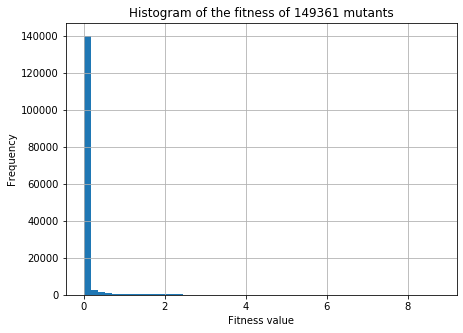

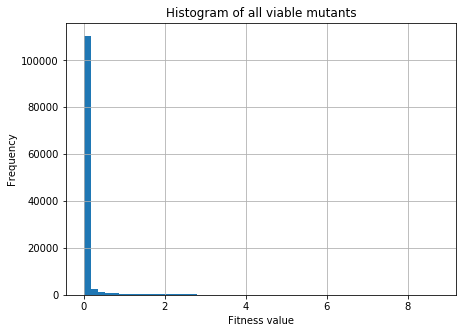

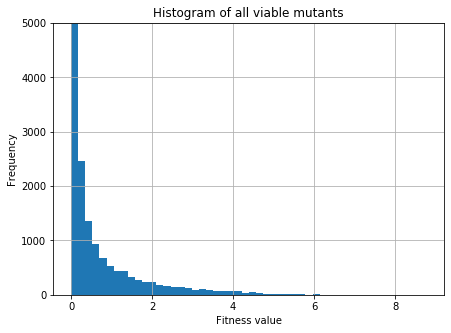

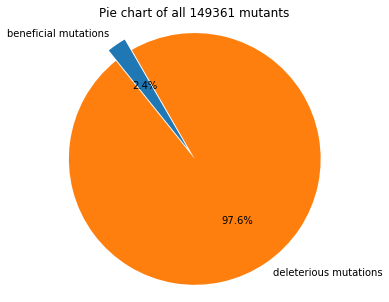

In [132]:
""" Histogram of the entire dataset. """

y['fitness'].hist(bins = 50,
                 figsize = (7,5))
plt.xlabel('Fitness value')
plt.ylabel('Frequency')
plt.title('Histogram of the fitness of 149361 mutants')
plt.show()

""" Plot excluding all fitness == 0 mutants. """

nonzero = y['fitness'].loc[y['fitness'].ne(0)]
# print(nonzero)
nonzero.hist(bins = 50,
             figsize = (7,5))
plt.xlabel('Fitness value')
plt.ylabel('Frequency')
plt.title('Histogram of all viable mutants')
plt.show()

""" Plot zooming into the dwarfed parts of the histogram. """

nonzero.hist(bins = 50,
             figsize = (7,5))
plt.ylim([0, 5000])
plt.xlabel('Fitness value')
plt.ylabel('Frequency')
plt.title('Histogram of all viable mutants')
plt.show()

""" Chart to show how only few of the variants have improved fitness. """

fitness_score_improved = (3643/149361)*100
fitness_score_worse = ((149361-3643)/149361)*100

labels = 'beneficial mutations', 'deleterious mutations'
sizes = [fitness_score_improved, fitness_score_worse]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=120)
ax1.axis('equal')
ax1.set_title('Pie chart of all 149361 mutants')
plt.show()

In [14]:
"""Extract index of all mutants with higher fitness"""

better_variants = y['fitness'].index[y['fitness'] > 1].tolist()
# print(better_variants)
print('Number of variants with fitness score above that of WT: ' + str(len(better_variants)))

Number of variants with fitness score above that of WT: 3643


In [15]:
"""Split into training and testing dataset"""

X_test1, X_train1, y_test1, y_train1 = train_test_split(X, y['fitness'], test_size=0.2, random_state=123)
print(X_train1)
# print(X_test.shape)
print(y_train1)
# print(y_test.shape)
print(X_test1)
print(y_test1)

        Pos39_Z1  Pos39_Z2  Pos39_Z3  Pos39_Z4  Pos39_Z5  Pos40_Z1  Pos40_Z2  \
88177      -4.28     -1.30     -1.49     -0.72      0.84      1.75      0.50   
34547       0.84     -1.67      3.71      0.18     -2.65     -3.89     -1.73   
63218       2.05     -4.06      0.36     -0.82     -0.38     -2.59     -2.64   
83975      -4.28     -1.30     -1.49     -0.72      0.84      0.24     -2.32   
85161      -4.28     -1.30     -1.49     -0.72      0.84     -4.22      1.94   
...          ...       ...       ...       ...       ...       ...       ...   
148496     -2.54      2.44      0.43      0.04     -1.47     -2.59     -2.64   
85438      -4.28     -1.30     -1.49     -0.72      0.84      2.05     -4.06   
27778      -2.54      2.44      0.43      0.04     -1.47     -4.28     -1.30   
7379        2.05     -4.06      0.36     -0.82     -0.38      3.11      0.26   
121225      3.52      2.50     -3.50      1.99     -0.17      1.75      0.50   

        Pos40_Z3  Pos40_Z4  Pos40_Z5  P

In [16]:
"""Compare training and test set"""

print(y_train1.idxmax(axis = 0), y_train1.max(axis = 0), y_train1.mean())
better_variants_train = y_train1.index[y_train1 > 1].tolist()
print('Number of variants with fitness score above that of WT in training set: ' + str(len(better_variants_train)))
print(y_test1.idxmax(axis = 0), y_test1.max(axis = 0), y_test1.mean())
better_variants_test = y_test1.index[y_test1 > 1].tolist()
print('Number of variants with fitness score above that of WT in testing set: ' + str(len(better_variants_test)))

89835 7.228660053 0.08176561841197728
Number of variants with fitness score above that of WT in training set: 737
57022 8.761965656 0.08019569135003371
Number of variants with fitness score above that of WT in testing set: 2906


In [17]:
"""Convert dataframe to data structure for xgboost"""

data_train1 = xgb.DMatrix(X_train1, label=y_train1)
data_test1 = xgb.DMatrix(X_test1, label=y_test1)
print(data_train1)
print(data_test1)

In [18]:
"""Save training and testing dataset in text file"""

dump_svmlight_file(X_train1, y_train1, 'data_train1.svm', zero_based=True)
dump_svmlight_file(X_test1, y_test1, 'data_test1.svm', zero_based=True)
dtrain_svm1 = xgb.DMatrix('data_train1.svm')
dtest_svm1 = xgb.DMatrix('data_test1.svm')

[09:41:46] 29873x20 matrix with 597460 entries loaded from data_train1.svm
[09:41:46] 119488x20 matrix with 2389760 entries loaded from data_test1.svm


In [30]:
"""Dictionary of relevant hyperparameters for xgboost"""

params1 = {
    'max_depth': 10, # the maximum depth of each tree i.e. how many 'leaves' it can grow
    'eta': 0.05,  # the training step for each iteration a.k.a. learning rate
    'colsample_bytree': 0.33, # how many columns are sampled from each mutant
    'gamma': 0,
    'eval_metric': 'rmse',
    'min_child_weight': 0,
    'subsample': 0.5,
#     'silent': 0,
#     'early_stopping_rounds': 10,
    'objective': 'reg:squarederror'}  # loss function; here, I use linear regression
num_round = 150  # the number of training iterations a.k.a. trees or boosts

In [31]:
"""Train the ML model with above parameters"""

model01 = xgb.train(params1, data_train1, num_round, evals=[(data_test1, "test")])
predictions = model01.predict(data_test1)
model01.dump_model('model01.txt')

[0]	test-rmse:0.55802
[1]	test-rmse:0.53661
[2]	test-rmse:0.51726
[3]	test-rmse:0.50376
[4]	test-rmse:0.48626
[5]	test-rmse:0.47075
[6]	test-rmse:0.45864
[7]	test-rmse:0.44771
[8]	test-rmse:0.43290
[9]	test-rmse:0.41815
[10]	test-rmse:0.40601
[11]	test-rmse:0.39366
[12]	test-rmse:0.38539
[13]	test-rmse:0.37471
[14]	test-rmse:0.36354
[15]	test-rmse:0.35222
[16]	test-rmse:0.34337
[17]	test-rmse:0.33494
[18]	test-rmse:0.32642
[19]	test-rmse:0.31959
[20]	test-rmse:0.31133
[21]	test-rmse:0.30390
[22]	test-rmse:0.29785
[23]	test-rmse:0.29158
[24]	test-rmse:0.28642
[25]	test-rmse:0.27981
[26]	test-rmse:0.27451
[27]	test-rmse:0.26965
[28]	test-rmse:0.26531
[29]	test-rmse:0.26153
[30]	test-rmse:0.25909
[31]	test-rmse:0.25559
[32]	test-rmse:0.25214
[33]	test-rmse:0.24840
[34]	test-rmse:0.24686
[35]	test-rmse:0.24380
[36]	test-rmse:0.24204
[37]	test-rmse:0.23874
[38]	test-rmse:0.23534
[39]	test-rmse:0.23399
[40]	test-rmse:0.23104
[41]	test-rmse:0.22810
[42]	test-rmse:0.22635
[43]	test-rmse:0.2257

In [134]:
"""Cross validation with testing dataset"""

cross_validation1 = xgb.cv(params1,
                          data_train1,
                          seed=123,
                          nfold=5,
                          metrics={'rmse'},
                          num_boost_round = num_round)
print(cross_validation1)

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           0.559471        0.002838        0.560732       0.011531
1           0.537729        0.003497        0.539817       0.010980
2           0.518157        0.003439        0.520966       0.012219
3           0.499640        0.004475        0.503340       0.011713
4           0.482166        0.005868        0.486771       0.010406
..               ...             ...             ...            ...
495         0.029242        0.000706        0.163118       0.006992
496         0.029179        0.000676        0.163102       0.007010
497         0.029120        0.000679        0.163073       0.006963
498         0.029034        0.000692        0.163049       0.006957
499         0.028959        0.000712        0.163057       0.006960

[500 rows x 4 columns]


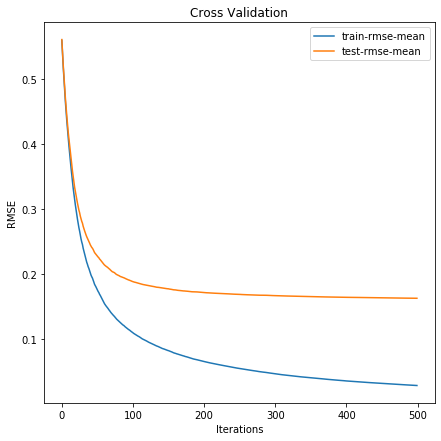

In [136]:
"""Plot the RMSE of the model fit to training and testing datasets to monitor overfitting"""

cross_validation_mean1 = cross_validation1.drop(['train-rmse-std', 'test-rmse-std'], axis=1)
cross_validation_mean1.plot(title = 'Cross Validation',
                            figsize = (7,7))
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show()

Pearson correlation is:
          fitness   model01
fitness  1.000000  0.910191
model01  0.910191  1.000000

Spearman correlation is:
          fitness   model01
fitness  1.000000  0.458892
model01  0.458892  1.000000


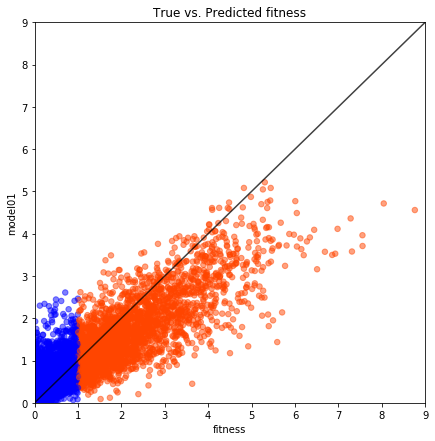

In [40]:
"""Plot the correlation of the true and predicted values"""

validation = predictions
# print(validation)
testdf1 = y_test1
testdf1 = testdf1.to_frame()
testdf1['model01'] = validation
# testdf.to_csv('first_pass.csv')

first_pass_pearson_correlation = testdf1.corr(method='pearson')
print('Pearson correlation is:')
print(first_pass_pearson_correlation)
# pearson_corr_val = first_pass_pearson_correlation['fitness'].values[1]
# print(pearson_corr_val)

first_pass_spearman_correlation = testdf1.corr(method='spearman')
print('\nSpearman correlation is:')
print(first_pass_spearman_correlation)

colors = ['orangered' if val > 1 else 'blue' for val in testdf1['fitness']]
testdf1.plot.scatter(x = 'fitness',
                     y = 'model01',
                     xlim = (0, 9),
                     ylim = (0, 9),
                     color = colors,
                     figsize = (7,7),
                     alpha = 0.5,
                     s = 30,
                     title = 'True vs. Predicted fitness')
plt.plot(range(10), color = 'black', alpha = 0.75)
plt.show()

True positives: 2270 (78.11424638678595%)
False negatives: 636 (21.88575361321404%)
True negatives: 116078 (99.56768626374568%)
False positives: 504 (0.43231373625431024%)


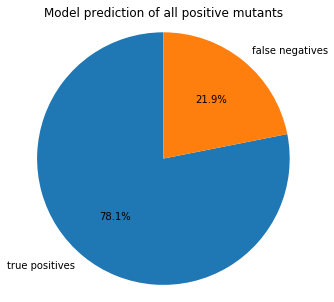

In [133]:
"""In the end, how many true positives did the model predict?"""

fp_true_positives = testdf1.index[(testdf1['fitness']>1)&(testdf1['model01']>1)].tolist()
fp_true_positives_percent = (len(fp_true_positives)/2906)*100
print('True positives: ' + str(len(fp_true_positives)) + ' (' + str(fp_true_positives_percent) + '%)')

fp_false_negatives = testdf1.index[(testdf1['fitness']>1)&(testdf1['model01']<=1)].tolist()
fp_false_negatives_percent = (len(fp_false_negatives)/2906)*100
print('False negatives: ' + str(len(fp_false_negatives)) + ' (' + str(fp_false_negatives_percent) + '%)')

fp_true_negatives = testdf1.index[(testdf1['fitness']<=1)&(testdf1['model01']<=1)].tolist()
fp_true_negatives_percent = (len(fp_true_negatives)/(119488-2906))*100
print('True negatives: ' + str(len(fp_true_negatives)) + ' (' + str(fp_true_negatives_percent) + '%)')

fp_false_positives = testdf1.index[(testdf1['fitness']<=1)&(testdf1['model01']>1)].tolist()
fp_false_positives_percent = (len(fp_false_positives)/(119488-2906))*100
print('False positives: ' + str(len(fp_false_positives)) + ' (' + str(fp_false_positives_percent) + '%)')

labels = 'true positives', 'false negatives'
sizes = [78.11, 21.89]

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        shadow=False,
        startangle=90)
ax1.axis('equal')
ax1.set_title('Model prediction of all positive mutants')
plt.show()

In [137]:
"""Did it correctly predict the top 10 variants?
Only one variant 57319 from the true top 10 is predicted"""

true_rank = testdf1.nlargest(10, 'fitness')
predicted_rank = testdf1.nlargest(10, 'model01')

In [138]:
print('Based on ground truth...')
true_rank

Based on ground truth...


,fitness,model01
57022,8.761966,4.558943
57319,8.045152,4.714816
30420,7.556869,3.708730
57040,7.554663,3.962855
57140,7.312656,3.578207
142103,7.282333,4.360919
149019,6.981333,4.114154
52238,6.928257,3.527339
142231,6.857543,3.497299
142246,6.689730,3.572345


In [139]:
print('Based on prediction...')
predicted_rank

Based on prediction...


,fitness,model01
140799,5.304778,5.214931
83886,5.440592,5.081701
85627,4.823405,5.081686
90182,5.260676,5.046875
85970,4.984427,4.870208
22992,5.430379,4.785050
76590,6.007627,4.769792
74156,5.367896,4.749864
89478,4.481237,4.737197
57319,8.045152,4.714816


In [52]:
"""Generate a new training dataset with a size similar to that reported in literature from
Xu et. al. 2020 Deep Dive into Machine Learning Models for Protein Engineering Journal of Chemical Information and Modeling"""

X_test2, X_train2, y_test2, y_train2 = train_test_split(X, y['fitness'], test_size=0.02, random_state=12)

"""Convert dataframe"""

data_train2 = xgb.DMatrix(X_train2, label=y_train2)
data_test2 = xgb.DMatrix(X_test2, label=y_test2)
print(data_train2)
print(data_test2)

In [53]:
"""Preparing hyperparameter dictionary for gridsearch optimization based on Table 2 in the paper"""

parameters = {
    'max_depth': [10, 15], # the maximum depth of each tree i.e. how many 'leaves' it can grow
    'eta': [0.01, 0.05],  # the training step for each iteration a.k.a. learning rate
    'colsample_bytree': [0.33, 0.667], # how many columns are sampled from each mutant
    'gamma': [0], # minimum loss reduction to make further partition on leaf node of tree
    'min_child_weight': [1], # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5],
#     'silent': 0,
    'early_stopping_rounds': [10],
    'num_round': [500, 1000, 1500]} # the number of training iterations a.k.a. trees or boosts

In [54]:
"""Tuning hyperparameters based on existing literature"""

estimator = xgb.XGBRegressor(objective= 'reg:squarederror', seed=42)

grid_search = GridSearchCV(estimator=estimator,
                           param_grid=parameters,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1,
                           cv = 5,
                           verbose=True)

grid_search.fit(X_train2, y_train2)
grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.7s


[10:22:48] WARNING: /Users/taumoefolaugh/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:485: 
Parameters: { early_stopping_rounds, num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   16.9s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.667,
             early_stopping_rounds=10, eta=0.05, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, num_round=500,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.5,
             tree_method='exact', validate_parameters=1, ...)

In [55]:
"""Prepare library with optimal params"""

opt_params = {
    'max_depth': 10, # the maximum depth of each tree i.e. how many 'leaves' it can grow
    'eta': 0.05,  # the training step for each iteration a.k.a. learning rate
    'colsample_bytree': 0.667, # how many columns are sampled from each mutant
    'gamma': 0,
#     'eval_metric': 'rmse',
    'min_child_weight': 1,
    'subsample': 0.5,
#     'silent': 0,
#     'early_stopping_rounds': 10,
    'objective': 'reg:squarederror'}  # loss function; here, I use linear regression
num_round = 500 # the number of training iterations a.k.a. trees or boosts

In [56]:
"""Train the ML model with optimized parameters"""

model02 = xgb.train(opt_params, data_train2, num_round, early_stopping_rounds=10, evals=[(data_test2, "test")])
predictions = model02.predict(data_test2)
model02.dump_model('model02.txt')

[0]	test-rmse:0.55675
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:0.53904
[2]	test-rmse:0.52173
[3]	test-rmse:0.50690
[4]	test-rmse:0.49143
[5]	test-rmse:0.47720
[6]	test-rmse:0.46368
[7]	test-rmse:0.45062
[8]	test-rmse:0.43940
[9]	test-rmse:0.42982
[10]	test-rmse:0.41879
[11]	test-rmse:0.40987
[12]	test-rmse:0.40280
[13]	test-rmse:0.39551
[14]	test-rmse:0.38804
[15]	test-rmse:0.38027
[16]	test-rmse:0.37370
[17]	test-rmse:0.36706
[18]	test-rmse:0.36121
[19]	test-rmse:0.35586
[20]	test-rmse:0.35069
[21]	test-rmse:0.34710
[22]	test-rmse:0.34354
[23]	test-rmse:0.33847
[24]	test-rmse:0.33405
[25]	test-rmse:0.33133
[26]	test-rmse:0.32792
[27]	test-rmse:0.32479
[28]	test-rmse:0.32237
[29]	test-rmse:0.32042
[30]	test-rmse:0.31788
[31]	test-rmse:0.31524
[32]	test-rmse:0.31304
[33]	test-rmse:0.31078
[34]	test-rmse:0.30843
[35]	test-rmse:0.30677
[36]	test-rmse:0.30578
[37]	test-rmse:0.30491
[38]	test-rmse:0.30322
[39]	test-rmse:0.30196
[40]	test-rmse:0.30112
[41]	test-

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           0.543912        0.007472        0.546807       0.034615
1           0.522704        0.007057        0.528943       0.035882
2           0.503410        0.006909        0.512348       0.037046
3           0.484994        0.007370        0.495837       0.038264
4           0.466210        0.006884        0.480038       0.039709
..               ...             ...             ...            ...
190         0.026431        0.000868        0.264989       0.043084
191         0.026216        0.000865        0.265031       0.043081
192         0.025972        0.000858        0.265029       0.043007
193         0.025698        0.000873        0.264946       0.042954
194         0.025418        0.000866        0.264913       0.042933

[195 rows x 4 columns]


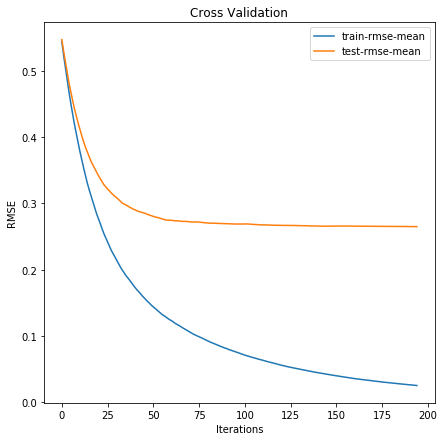

In [57]:
"""Cross validation"""

cross_validation2 = xgb.cv(opt_params,
                          data_train2,
                          seed=123,
                          nfold=5,
                          metrics={'rmse'},
                          num_boost_round = 195)
print(cross_validation2)

cross_validation_mean2 = cross_validation2.drop(['train-rmse-std', 'test-rmse-std'], axis=1)
cross_validation_mean2.plot(title = 'Cross Validation',
                            figsize = (7,7))
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show()

Pearson correlation is:
          fitness   model02
fitness  1.000000  0.718456
model02  0.718456  1.000000

Spearman correlation is:
          fitness   model02
fitness  1.000000  0.453756
model02  0.453756  1.000000


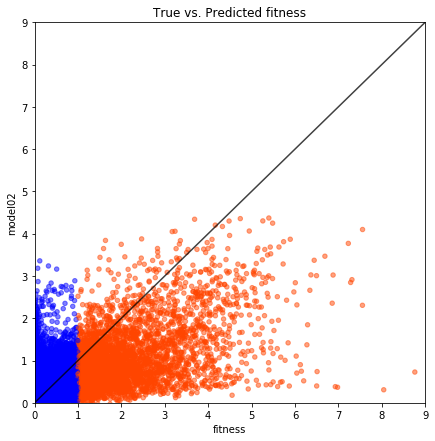

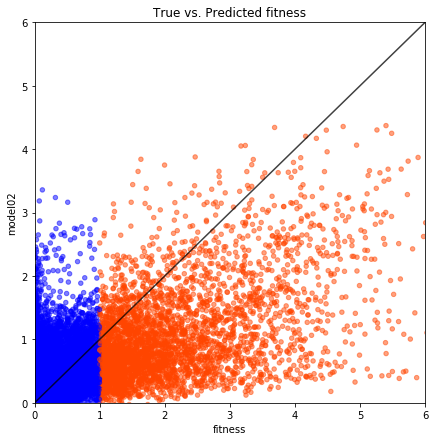

In [60]:
"""Plot the correlation of the true and predicted values"""

literature = predictions
# print(validation)
testdf2 = y_test2
testdf2 = testdf2.to_frame()
testdf2['model02'] = literature
# print(y_test)
# print(testdf)
# testdf.to_csv('first_pass.csv')

literature_pearson_correlation = testdf2.corr(method='pearson')
print('Pearson correlation is:')
print(literature_pearson_correlation)
# pearson_corr_val = first_pass_pearson_correlation['fitness'].values[1]
# print(pearson_corr_val)

literature_spearman_correlation = testdf2.corr(method='spearman')
print('\nSpearman correlation is:')
print(literature_spearman_correlation)

colors = ['orangered' if val > 1 else 'blue' for val in testdf2['fitness']]
testdf2.plot.scatter(x = 'fitness',
                    y = 'model02',
                    xlim = (0, 9),
                    ylim = (0, 9),
                    color = colors,
                    figsize = (7,7),
                    alpha = 0.5,
                    title = 'True vs. Predicted fitness')
plt.plot(range(10), color = 'black', alpha = 0.75)
plt.show()

colors = ['orangered' if val > 1 else 'blue' for val in testdf2['fitness']]
testdf2.plot.scatter(x = 'fitness',
                    y = 'model02',
                    xlim = (0, 6),
                    ylim = (0, 6),
                    color = colors,
                    figsize = (7,7),
                    alpha = 0.5,
                    title = 'True vs. Predicted fitness')
plt.plot(range(10), color = 'black', alpha = 0.75)
plt.show()

True positives: 1617 (45.218120805369125%)
False negatives: 1959 (54.78187919463087%)
True negatives: 141972 (99.42225677010022%)
False positives: 825 (0.5777432298997879%)


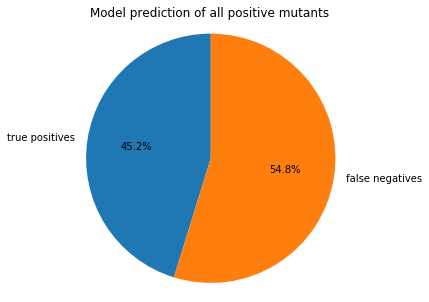

In [142]:
"""Some numbers"""

fp_true_positives = testdf2.index[(testdf2['fitness']>1)&(testdf2['model02']>1)].tolist()
fp_true_positives_percent = (len(fp_true_positives)/(3576))*100
print('True positives: ' + str(len(fp_true_positives)) + ' (' + str(fp_true_positives_percent) + '%)')

fp_false_negatives = testdf2.index[(testdf2['fitness']>1)&(testdf2['model02']<=1)].tolist()
fp_false_negatives_percent = (len(fp_false_negatives)/(3576))*100
print('False negatives: ' + str(len(fp_false_negatives)) + ' (' + str(fp_false_negatives_percent) + '%)')

fp_true_negatives = testdf2.index[(testdf2['fitness']<=1)&(testdf2['model02']<=1)].tolist()
fp_true_negatives_percent = (len(fp_true_negatives)/(142797))*100
print('True negatives: ' + str(len(fp_true_negatives)) + ' (' + str(fp_true_negatives_percent) + '%)')

# print('False positives: ' + str(len(fp_correctly_predicted)) + ' (' + str(fp_percent) + '%)')
fp_false_positives = testdf2.index[(testdf2['fitness']<=1)&(testdf2['model02']>1)].tolist()
fp_false_positives_percent = (len(fp_false_positives)/(142797))*100
print('False positives: ' + str(len(fp_false_positives)) + ' (' + str(fp_false_positives_percent) + '%)')

labels = 'true positives', 'false negatives'
sizes = [45.22, 54.78]

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')
ax1.set_title('Model prediction of all positive mutants')
plt.show()

In [64]:
"""Generate a new training dataset on the premise that a student screens several hundred mutants"""

X_test3, X_train3, y_test3, y_train3 = train_test_split(X, y['fitness'], test_size=500, random_state=33)

"""Convert dataframe"""

data_train3 = xgb.DMatrix(X_train3, label=y_train3)
data_test3 = xgb.DMatrix(X_test3, label=y_test3)
print(data_train3)
print(data_test3)

In [65]:
"""Preparing hyperparameter dictionary for optimization with more added values"""

param_search = {
    'max_depth': [5, 10, 15], # the maximum depth of each tree i.e. how many 'leaves' it can grow
    'eta': [0.01, 0.05],  # the training step for each iteration a.k.a. learning rate
    'colsample_bytree': [0.33, 0.667, 1], # how many columns are sampled from each mutant
    'gamma': [0, 1, 5],
#     'eval_metric': 'rmse',
    'min_child_weight': [0, 1, 10],
    'subsample': [0.5],
#     'silent': 0,
    'early_stopping_rounds': [10],
    'num_round': [500, 1000, 1500]} # the number of training iterations a.k.a. trees or boosts
#     'objective': 'reg:squarederror'}  # loss function; here, I use linear regression

In [66]:
"""Tuning hyperparameters"""

estimator = xgb.XGBRegressor(objective= 'reg:squarederror', seed=42)

grid_search = GridSearchCV(estimator=estimator,
                           param_grid=param_search,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1,
                           cv = 5,
                           verbose=True)

grid_search.fit(X_train3, y_train3)
grid_search.best_estimator_

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   11.5s


[10:35:06] WARNING: /Users/taumoefolaugh/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:485: 
Parameters: { early_stopping_rounds, num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:   21.0s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.667,
             early_stopping_rounds=10, eta=0.05, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, num_round=500,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.5,
             tree_method='exact', validate_parameters=1, ...)

In [67]:
"""Prepare library with optimized parameters"""

opt_params = {
    'max_depth': 5, # the maximum depth of each tree i.e. how many 'leaves' it can grow
    'eta': 0.05,  # the training step for each iteration a.k.a. learning rate
    'colsample_bytree': 0.667, # how many columns are sampled from each mutant
    'gamma': 0,
#     'eval_metric': 'rmse',
    'min_child_weight': 10,
    'subsample': 0.5,
#     'silent': 0,
#     'early_stopping_rounds': 10,
    'objective': 'reg:squarederror'}  # loss function; here, I use linear regression
num_round = 500 # the number of training iterations a.k.a. trees or boosts

In [70]:
"""Train the ML model with optimized parameters"""

model03 = xgb.train(opt_params, data_train3, num_round, early_stopping_rounds=50, evals=[(data_test3, "test")])
predictions = model03.predict(data_test3)
model03.dump_model('model03.txt')

[0]	test-rmse:0.56012
Will train until test-rmse hasn't improved in 50 rounds.
[1]	test-rmse:0.54520
[2]	test-rmse:0.53280
[3]	test-rmse:0.52098
[4]	test-rmse:0.50883
[5]	test-rmse:0.49880
[6]	test-rmse:0.48801
[7]	test-rmse:0.47873
[8]	test-rmse:0.46936
[9]	test-rmse:0.46056
[10]	test-rmse:0.45396
[11]	test-rmse:0.44700
[12]	test-rmse:0.43995
[13]	test-rmse:0.43377
[14]	test-rmse:0.42777
[15]	test-rmse:0.42243
[16]	test-rmse:0.41847
[17]	test-rmse:0.41441
[18]	test-rmse:0.41103
[19]	test-rmse:0.40745
[20]	test-rmse:0.40370
[21]	test-rmse:0.40106
[22]	test-rmse:0.39790
[23]	test-rmse:0.39465
[24]	test-rmse:0.39246
[25]	test-rmse:0.39052
[26]	test-rmse:0.38822
[27]	test-rmse:0.38657
[28]	test-rmse:0.38509
[29]	test-rmse:0.38336
[30]	test-rmse:0.38204
[31]	test-rmse:0.38068
[32]	test-rmse:0.37969
[33]	test-rmse:0.37805
[34]	test-rmse:0.37660
[35]	test-rmse:0.37528
[36]	test-rmse:0.37433
[37]	test-rmse:0.37201
[38]	test-rmse:0.37123
[39]	test-rmse:0.37075
[40]	test-rmse:0.37023
[41]	test-

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           0.578447        0.019508        0.575450       0.075670
1           0.563888        0.020409        0.561560       0.078566
2           0.550403        0.021524        0.548026       0.080730
3           0.537436        0.022359        0.535989       0.083913
4           0.525378        0.022628        0.525889       0.086366
..               ...             ...             ...            ...
152         0.264947        0.019406        0.394775       0.133080
153         0.264420        0.019492        0.394450       0.132918
154         0.263912        0.019429        0.394019       0.132526
155         0.263313        0.019154        0.394161       0.132500
156         0.263061        0.019097        0.394184       0.132342

[157 rows x 4 columns]


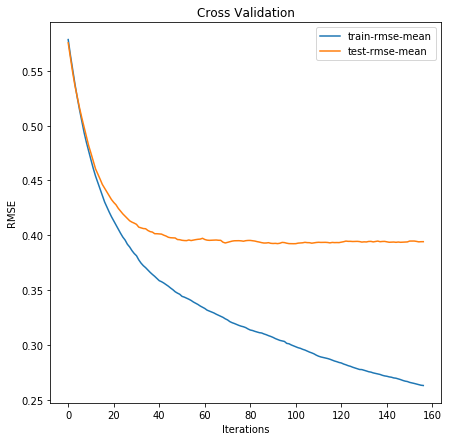

In [69]:
"""Cross validation"""

cross_validation3 = xgb.cv(opt_params,
                          data_train3,
                          nfold=5,
                          metrics={'rmse'},
                          num_boost_round = 157)
print(cross_validation3)

cross_validation_mean3 = cross_validation3.drop(['train-rmse-std', 'test-rmse-std'], axis=1)
cross_validation_mean3.plot(title = 'Cross Validation',
                            figsize = (7,7))
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show()

Pearson correlation is:
          fitness   model03
fitness  1.000000  0.437163
model03  0.437163  1.000000

Spearman correlation is:
         fitness  model03
fitness  1.00000  0.39387
model03  0.39387  1.00000


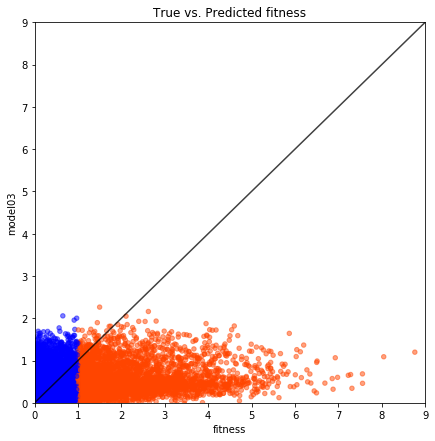

In [71]:
"""Plot the correlation of the true and predicted values"""

experiment = predictions
# print(validation)
testdf3 = y_test3
testdf3 = testdf3.to_frame()
testdf3['model03'] = experiment
# print(y_test)
# print(testdf)
# testdf.to_csv('first_pass.csv')

literature_pearson_correlation = testdf3.corr(method='pearson')
print('Pearson correlation is:')
print(literature_pearson_correlation)
# pearson_corr_val = first_pass_pearson_correlation['fitness'].values[1]
# print(pearson_corr_val)

literature_spearman_correlation = testdf3.corr(method='spearman')
print('\nSpearman correlation is:')
print(literature_spearman_correlation)

colors = ['orangered' if val > 1 else 'blue' for val in testdf3['fitness']]
testdf3.plot.scatter(x = 'fitness',
                    y = 'model03',
                    xlim = (0, 9),
                    ylim = (0, 9),
                    color = colors,
                    figsize = (7,7),
                    alpha = 0.5,
                    title = 'True vs. Predicted fitness')
plt.plot(range(10), color = 'black', alpha = 0.75)
plt.show()

True positives: 516 (14.218793055938276%)
False negatives: 3113 (85.78120694406172%)
True negatives: 144715 (99.64401784730637%)
False positives: 517 (0.35598215269362127%)


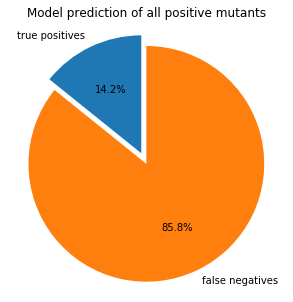

In [143]:
"""Some numbers"""


fp_true_positives = testdf3.index[(testdf3['fitness']>1)&(testdf3['model03']>1)].tolist()
fp_true_positives_percent = (len(fp_true_positives)/(3629))*100
print('True positives: ' + str(len(fp_true_positives)) + ' (' + str(fp_true_positives_percent) + '%)')

fp_false_negatives = testdf3.index[(testdf3['fitness']>1)&(testdf3['model03']<=1)].tolist()
fp_false_negatives_percent = (len(fp_false_negatives)/(3629))*100
print('False negatives: ' + str(len(fp_false_negatives)) + ' (' + str(fp_false_negatives_percent) + '%)')

fp_true_negatives = testdf3.index[(testdf3['fitness']<=1)&(testdf3['model03']<=1)].tolist()
fp_true_negatives_percent = (len(fp_true_negatives)/(145232))*100
print('True negatives: ' + str(len(fp_true_negatives)) + ' (' + str(fp_true_negatives_percent) + '%)')

fp_false_positives = testdf3.index[(testdf3['fitness']<=1)&(testdf3['model03']>1)].tolist()
fp_false_positives_percent = (len(fp_false_positives)/(145232))*100
print('False positives: ' + str(len(fp_false_positives)) + ' (' + str(fp_false_positives_percent) + '%)')

labels = 'true positives', 'false negatives'
sizes = [14.22, 85.78]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')
ax1.set_title('Model prediction of all positive mutants')
plt.show()

In [94]:
"""Extract the top 200 variants from testing dataset based on predictions
and add to training dataset the ground truth fitness to second round of screening.
Then retrain the model. Remove newly tested variants from testing dataset.
This should enrich the training dataset with positive mutants."""

y_new_variants = testdf3.nlargest(200, 'model03')
X_new_variants = X_test3.loc[y_new_variants.index, :]
# print(y_new_variants)
# print(X_new_variants)
# print(new_variants['fitness'])

y_train3_updated = pd.concat([y_train3, y_new_variants['fitness']])
X_train3_updated = pd.concat([X_train3, X_new_variants])
# print(X_train3_updated)
y_test3_updated = y_test3.drop(y_new_variants.index)
X_test3_updated = X_test3.drop(X_new_variants.index)
# print(len(y_test3), len(X_test3), len(y_test3_updated), len(X_test3_updated))

148861 148861 148661 148661


In [96]:
data_train3_updated = xgb.DMatrix(X_train3_updated, label=y_train3_updated)
data_test3_updated = xgb.DMatrix(X_test3_updated, label=y_test3_updated)
print(data_train3_updated)
print(data_test3_updated)

In [97]:
"""Preparing hyperparameter dictionary for optimization"""

param_search = {
    'max_depth': [5, 10, 15], # the maximum depth of each tree i.e. how many 'leaves' it can grow
    'eta': [0.01, 0.05],  # the training step for each iteration a.k.a. learning rate
    'colsample_bytree': [0.33, 0.667, 1], # how many columns are sampled from each mutant
    'gamma': [0, 1, 5],
#     'eval_metric': 'rmse',
    'min_child_weight': [0, 1, 10],
    'subsample': [0.5],
#     'silent': 0,
    'early_stopping_rounds': [10],
    'num_round': [500, 1000, 1500]} # the number of training iterations a.k.a. trees or boosts
#     'objective': 'reg:squarederror'}  # loss function; here, I use linear regression

In [98]:
"""Tuning hyperparameters"""

estimator = xgb.XGBRegressor(objective= 'reg:squarederror', seed=42)

grid_search = GridSearchCV(estimator=estimator,
                           param_grid=param_search,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1,
                           cv = 5,
                           verbose=True)

grid_search.fit(X_train3_updated, y_train3_updated)
grid_search.best_estimator_

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   30.5s


[11:22:45] WARNING: /Users/taumoefolaugh/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:485: 
Parameters: { early_stopping_rounds, num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:   31.3s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             eta=0.05, gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0500000007,
             max_delta_step=0, max_depth=15, min_child_weight=0, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, num_round=500, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, subsample=0.5, tree_method='exact', validate_parameters=1, ...)

In [99]:
"""Prepare library with optimized parameters"""

opt_params = {
    'max_depth': 15, # the maximum depth of each tree i.e. how many 'leaves' it can grow
    'eta': 0.05,  # the training step for each iteration a.k.a. learning rate
    'colsample_bytree': 1, # how many columns are sampled from each mutant
    'gamma': 0,
#     'eval_metric': 'rmse',
    'min_child_weight': 0,
    'subsample': 0.5,
#     'silent': 0,
#     'early_stopping_rounds': 10,
    'objective': 'reg:squarederror'}  # loss function; here, I use linear regression
num_round = 500 # the number of training iterations a.k.a. trees or boosts

In [101]:
"""Train the ML model with optimized parameters"""

model03_updated = xgb.train(opt_params, data_train3_updated, num_round, early_stopping_rounds=10, evals=[(data_test3_updated, "test")])
predictions = model03_updated.predict(data_test3_updated)
model03_updated.dump_model('model03_updated.txt')

[0]	test-rmse:0.55708
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:0.54061
[2]	test-rmse:0.52512
[3]	test-rmse:0.51261
[4]	test-rmse:0.49928
[5]	test-rmse:0.48701
[6]	test-rmse:0.47631
[7]	test-rmse:0.46698
[8]	test-rmse:0.45774
[9]	test-rmse:0.44915
[10]	test-rmse:0.44128
[11]	test-rmse:0.43448
[12]	test-rmse:0.42754
[13]	test-rmse:0.42107
[14]	test-rmse:0.41518
[15]	test-rmse:0.40856
[16]	test-rmse:0.40376
[17]	test-rmse:0.39972
[18]	test-rmse:0.39614
[19]	test-rmse:0.39284
[20]	test-rmse:0.38909
[21]	test-rmse:0.38670
[22]	test-rmse:0.38410
[23]	test-rmse:0.38181
[24]	test-rmse:0.38016
[25]	test-rmse:0.37754
[26]	test-rmse:0.37598
[27]	test-rmse:0.37442
[28]	test-rmse:0.37354
[29]	test-rmse:0.37220
[30]	test-rmse:0.37081
[31]	test-rmse:0.36974
[32]	test-rmse:0.36744
[33]	test-rmse:0.36636
[34]	test-rmse:0.36552
[35]	test-rmse:0.36450
[36]	test-rmse:0.36388
[37]	test-rmse:0.36359
[38]	test-rmse:0.36272
[39]	test-rmse:0.36152
[40]	test-rmse:0.36107
[41]	test-

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          1.040945        0.031240        1.038308       0.133047
1          1.001852        0.029464        1.006208       0.131710
2          0.967219        0.028707        0.975307       0.129062
3          0.933360        0.027826        0.944081       0.128274
4          0.899363        0.027195        0.914126       0.124985
..              ...             ...             ...            ...
83         0.156863        0.011374        0.426919       0.085846
84         0.154795        0.011124        0.426248       0.085729
85         0.152717        0.011145        0.425403       0.086028
86         0.151149        0.011080        0.424859       0.086434
87         0.148925        0.010825        0.424973       0.086324

[88 rows x 4 columns]


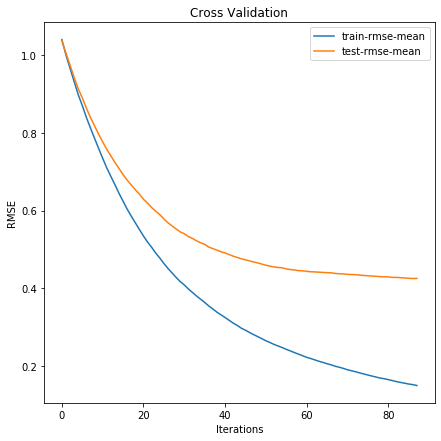

In [102]:
"""Cross validation"""

cross_validation3_updated = xgb.cv(opt_params,
                                   data_train3_updated,
                                   nfold=5,
                                   metrics={'rmse'},
                                   num_boost_round = 88)
print(cross_validation3_updated)

cross_validation3_updated = cross_validation3_updated.drop(['train-rmse-std', 'test-rmse-std'], axis=1)
cross_validation3_updated.plot(title = 'Cross Validation',
                               figsize = (7,7))
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show()

Pearson correlation is:
                  fitness  model03_updated
fitness          1.000000         0.479151
model03_updated  0.479151         1.000000

Spearman correlation is:
                  fitness  model03_updated
fitness          1.000000         0.426625
model03_updated  0.426625         1.000000


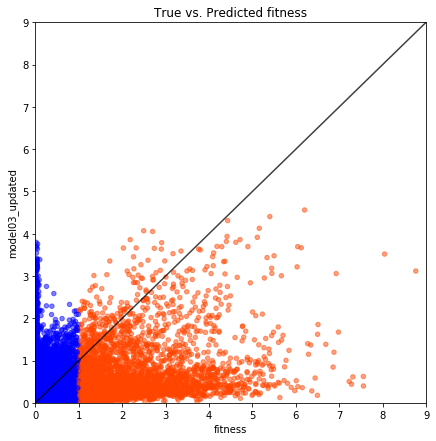

In [103]:
"""Plot the correlation of the true and predicted values"""

second_round = predictions
# print(validation)
testdf3_updated = y_test3_updated
testdf3_updated = testdf3_updated.to_frame()
testdf3_updated['model03_updated'] = second_round
# print(y_test)
# print(testdf)
# testdf.to_csv('first_pass.csv')

literature_pearson_correlation = testdf3_updated.corr(method='pearson')
print('Pearson correlation is:')
print(literature_pearson_correlation)
# pearson_corr_val = first_pass_pearson_correlation['fitness'].values[1]
# print(pearson_corr_val)

literature_spearman_correlation = testdf3_updated.corr(method='spearman')
print('\nSpearman correlation is:')
print(literature_spearman_correlation)

colors = ['orangered' if val > 1 else 'blue' for val in testdf3_updated['fitness']]
testdf3_updated.plot.scatter(x = 'fitness',
                             y = 'model03_updated',
                             xlim = (0, 9),
                             ylim = (0, 9),
                             color = colors,
                             figsize = (7,7),
                             alpha = 0.5,
                             title = 'True vs. Predicted fitness')
plt.plot(range(10), color = 'black', alpha = 0.75)
plt.show()

True positives: 761 (21.74285714285714%)
False negatives: 2739 (78.25714285714285%)
True negatives: 144241 (99.36622095466413%)
False positives: 920 (0.6337790453358684%)


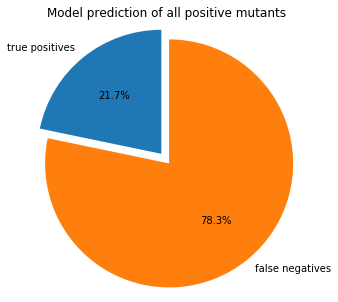

In [144]:
"""Some numbers"""

fp_true_positives = testdf3_updated.index[(testdf3_updated['fitness']>1)&(testdf3_updated['model03_updated']>1)].tolist()
fp_true_positives_percent = (len(fp_true_positives)/(3500))*100
print('True positives: ' + str(len(fp_true_positives)) + ' (' + str(fp_true_positives_percent) + '%)')

fp_false_negatives = testdf3_updated.index[(testdf3_updated['fitness']>1)&(testdf3_updated['model03_updated']<=1)].tolist()
fp_false_negatives_percent = (len(fp_false_negatives)/(3500))*100
print('False negatives: ' + str(len(fp_false_negatives)) + ' (' + str(fp_false_negatives_percent) + '%)')

fp_true_negatives = testdf3_updated.index[(testdf3_updated['fitness']<=1)&(testdf3_updated['model03_updated']<=1)].tolist()
fp_true_negatives_percent = (len(fp_true_negatives)/(145161))*100
print('True negatives: ' + str(len(fp_true_negatives)) + ' (' + str(fp_true_negatives_percent) + '%)')

fp_false_positives = testdf3_updated.index[(testdf3_updated['fitness']<=1)&(testdf3_updated['model03_updated']>1)].tolist()
fp_false_positives_percent = (len(fp_false_positives)/(145161))*100
print('False positives: ' + str(len(fp_false_positives)) + ' (' + str(fp_false_positives_percent) + '%)')

labels = 'true positives', 'false negatives'
sizes = [21.74, 78.26]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')
ax1.set_title('Model prediction of all positive mutants')
plt.show()

In [147]:
"""What are the predicted values for fitness?"""

true_rank03 = testdf3.nlargest(10, 'fitness')
predicted_rank03 = testdf3.nlargest(10, 'model03')
print('Based on ground truth...')
print(true_rank03)
print('Based on prediction...')
predicted_rank03

Based on ground truth...
         fitness   model03
57022   8.761966  1.198051
57319   8.045152  1.088634
30420   7.556869  0.460783
57040   7.554663  0.684124
57140   7.312656  0.343450
142103  7.282333  0.668284
89835   7.228660  0.650186
149019  6.981333  0.602189
52238   6.928257  1.064745
142235  6.877949  0.321511
Based on prediction...


,fitness,model03
9058,1.498893,2.263615
9044,2.621713,2.159736
9047,0.651184,2.056005
9043,2.107353,2.049175
1039,0.970376,2.001602
9049,0.911516,1.955193
1025,2.800273,1.933074
18,2.401243,1.926747
5891,2.546483,1.924228
11177,1.445506,1.895564


In [149]:
print('After adding 200 variants suggested by machine learning...')

true_rank03_updated = testdf3_updated.nlargest(10, 'fitness')
predicted_rank03_updated = testdf3_updated.nlargest(10, 'model03_updated')
print('Based on ground truth...')
print(true_rank03_updated)
print('Based on prediction...')
predicted_rank03_updated

After adding 200 variants suggested by machine learning...
Based on ground truth...
         fitness  model03_updated
57022   8.761966         3.117043
57319   8.045152         3.518274
30420   7.556869         0.398112
57040   7.554663         0.623160
57140   7.312656         0.613602
142103  7.282333         0.440290
89835   7.228660         0.506620
149019  6.981333         1.672205
52238   6.928257         3.056872
142235  6.877949         1.196319
Based on prediction...


,fitness,model03_updated
19549,6.201135,4.559673
22974,5.399750,4.404688
76915,4.425813,4.309356
25713,5.156918,4.127942
73434,2.493527,4.069154
22275,2.698467,4.051871
87361,4.413890,3.935364
21254,5.110624,3.913486
72404,4.713122,3.859090
71371,2.182272,3.858042


# Conclusions

1. ML-assisted directed evolution helps relate amino acid physiochemical properties to function.
2. Hyperparameters are not transferable across dataset.
3. Small training set can still assist protein engineering efforts
    - In terms of predicting all true positives, incorporating second screening sees modest improvement.
    - On a more practical level, ML-assisted second screening helps identify fitter mutants.